## Stock Performance Tracker


## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pyxirr import xirr

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# plt.style.use("fivethirtyeight")

user_name_l = ["ta", "tl"]
user_combined = "user_combined"
user_name_combined_l = user_name_l + [user_combined]

index_combined = "index_combined"
index_name_l = ["vni", "vn30"]
index_name_combined_l = index_name_l + [index_combined]


## Utils

In [3]:
def add_labels(ax, x, y, label_l=None, color=None):
    if label_l is None:
        label_l = [f"{y_i:.1f}" for y_i in y]
    for xi, yi, label in zip(x, y, label_l):
        max_y = max(y)
        y_pos_delta = max_y * 0.15
        y_pos_delta = y_pos_delta if yi > 0 else -y_pos_delta
        ax.text(xi, yi + y_pos_delta, label, ha="center", color=color)


def add_trend_line(ax, ticks, x, y):
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(ticks, p(x), ":", alpha=0.7)


def _calc_cashflow_xirr(
    cashflow_df: pd.DataFrame,
    log_df: pd.DataFrame,
    anchor_date: str | None,
    date_idx: pd.Timestamp,
    col_name: str,
) -> float:
    # remove cashflow after date_idx
    cashflow_df = cashflow_df.loc[cashflow_df.index <= date_idx]

    # if anchor_date is provided, we have to determined the amount at anchor date,
    # and only use cashflow after that anchor date
    if anchor_date is not None:
        cashflow_df = cashflow_df.loc[cashflow_df.index >= anchor_date]  # type: ignore
        # earlier date is the last date before anchor date
        earlier_df = log_df.loc[log_df.index < anchor_date]  # type: ignore
        if not earlier_df.empty:
            anchor_date_idx = earlier_df.index[-1]

            # Note: earliest amount should be negative since it's viewed as an investment
            earliest_amount_dict = {
                name: -log_df.loc[anchor_date_idx, name]  # type: ignore
                for name in user_name_combined_l
            }
            earliest_amount_df = pd.DataFrame(
                earliest_amount_dict, index=[anchor_date_idx]
            )

            cashflow_df = pd.concat([earliest_amount_df, cashflow_df])

    latest_amount_dict = {
        name: log_df.loc[date_idx, name] for name in user_name_combined_l
    }
    latest_amount_df = pd.DataFrame(latest_amount_dict, index=[date_idx])

    xirr_cf_df = pd.concat([cashflow_df, latest_amount_df])

    amounts = xirr_cf_df[col_name]
    if all(amounts == 0):  # type: ignore
        return 0

    xirr_val = xirr(xirr_cf_df.index, amounts)  # type: ignore
    return 0 if xirr_val is None else xirr_val


def _calc_index_xirr(
    log_dataframe: pd.DataFrame,
    anchor_date: str | None,
    date_idx: pd.Timestamp,
    index_name: str,
) -> float:
    if anchor_date is not None:
        earlier_df = log_dataframe.loc[log_dataframe.index < anchor_date]  # type: ignore

        # anchor_date_idx should be the last date before anchor date
        if not earlier_df.empty:
            anchor_date_idx = earlier_df.index[-1]
        else:
            anchor_date_idx = anchor_date

        log_dataframe = log_dataframe.loc[log_dataframe.index >= anchor_date_idx]  # type: ignore
    first_idx = log_dataframe.index[0]

    return xirr(
        [first_idx, date_idx],
        [
            -log_dataframe.loc[first_idx, index_name],  # type: ignore
            log_dataframe.loc[date_idx, index_name],
        ],
    )  # type: ignore


## Read data


### Log table


In [4]:
log_df = pd.read_csv("./stock_data - log.csv", index_col="date", parse_dates=True)
log_df = log_df.sort_index()  # type: ignore
log_df.tail()


,ta,tl,vni,vn30
date,,,,
2022-01-26,173345446,414219519,1481.58,1525.31
2022-01-27,172484480,411899443,1470.76,1516.57
2022-01-28,173094888,412223583,1478.96,1532.24
2022-02-07,177204864,423039188,1497.66,1541.25
2022-02-08,177240170,423830264,1497.66,1541.25


In [5]:
assert log_df.index.inferred_type == "datetime64"
log_df.dtypes


ta        int64
tl        int64
vni     float64
vn30    float64
dtype: object

### Cashflow


In [6]:
ta_cf_df = pd.read_csv(
    "./stock_data - ta_cashflow.csv",
    index_col="date",
    parse_dates=True,
)
tl_cf_df = pd.read_csv(
    "./stock_data - tl_cashflow.csv",
    index_col="date",
    parse_dates=True,
)
cf_df = pd.concat([ta_cf_df, tl_cf_df], axis=1)  # type: ignore
assert cf_df.index.inferred_type == "datetime64"
cf_df.fillna(0, inplace=True)
cf_df[user_combined] = cf_df.sum(axis=1)
cf_df.tail()


,ta,tl,user_combined
date,,,
2021-12-24,2300000.0,0.0,2300000.0
2022-01-05,0.0,289.0,289.0
2022-01-24,3224000.0,0.0,3224000.0
2022-01-28,-10121.0,1434000.0,1423879.0
2022-02-07,-552000.0,0.0,-552000.0


## [Chart] Index over time


/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_43551/1099213873.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(log_df.index, log_df["vni"], label="vni", linestyle="-", marker=None)
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_43551/1099213873.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(log_df.index, log_df["vn30"], label="vn30", linestyle="-", marker=None)


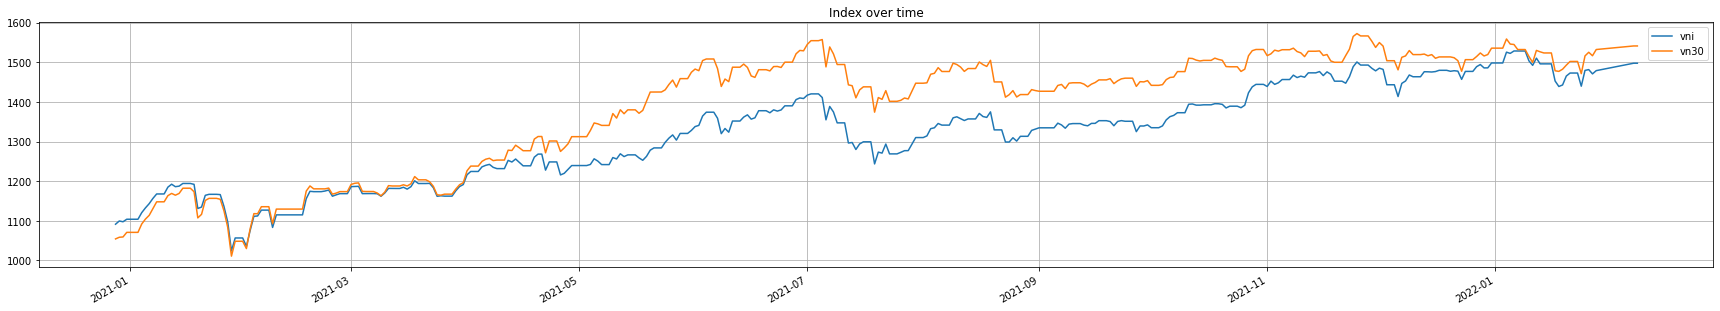

In [7]:
plt.figure(figsize=(30, 5))
plt.plot_date(log_df.index, log_df["vni"], label="vni", linestyle="-", marker=None)
plt.plot_date(log_df.index, log_df["vn30"], label="vn30", linestyle="-", marker=None)

plt.title("Index over time")

plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(True)

plt.show()


## [Process] Processing


### Adding diff columns


In [8]:
for name in user_name_l + index_name_l:
    log_df[f"{name}_diff"] = log_df[name].diff()
log_df.tail()


,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff
date,,,,,,,,
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74
2022-01-28,173094888,412223583,1478.96,1532.24,610408.0,324140.0,8.20,15.67
2022-02-07,177204864,423039188,1497.66,1541.25,4109976.0,10815605.0,18.70,9.01
2022-02-08,177240170,423830264,1497.66,1541.25,35306.0,791076.0,0.00,0.00


### Remove unchanged dates from `log_df`


In [9]:
unchanged_filt = log_df[f"{user_name_l[0]}_diff"] == 0
log_df = log_df.loc[~unchanged_filt]
log_df.tail()


,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff
date,,,,,,,,
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74
2022-01-28,173094888,412223583,1478.96,1532.24,610408.0,324140.0,8.20,15.67
2022-02-07,177204864,423039188,1497.66,1541.25,4109976.0,10815605.0,18.70,9.01
2022-02-08,177240170,423830264,1497.66,1541.25,35306.0,791076.0,0.00,0.00


### Compensating diff with cashflow


In [10]:
for user_name in user_name_l:
    log_df[f"{user_name}_diff"] = log_df[f"{user_name}_diff"].add(
        cf_df[user_name], fill_value=0
    )
log_df.tail()

,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff
date,,,,,,,,
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74
2022-01-28,173094888,412223583,1478.96,1532.24,600287.0,1758140.0,8.20,15.67
2022-02-07,177204864,423039188,1497.66,1541.25,3557976.0,10815605.0,18.70,9.01
2022-02-08,177240170,423830264,1497.66,1541.25,35306.0,791076.0,0.00,0.00


### Adding Combined columns


In [11]:
# Diff for user
diff_user_column_name_l = [f"{user_name}_diff" for user_name in user_name_l]

log_df[user_combined] = log_df[user_name_l].sum(axis=1)
log_df[f"{user_combined}_diff"] = log_df[diff_user_column_name_l].sum(axis=1)

# Diff for index
diff_index_column_name_l = [f"{index_name}_diff" for index_name in index_name_l]

log_df[index_combined] = log_df[index_name_l].mean(axis=1)
log_df[f"{index_combined}_diff"] = log_df[diff_index_column_name_l].mean(axis=1)

log_df.tail()


,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff,user_combined,user_combined_diff,index_combined,index_combined_diff
date,,,,,,,,,,,,
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15,587564965,12856268.0,1503.445,5.575
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74,584383923,-3181042.0,1493.665,-9.780
2022-01-28,173094888,412223583,1478.96,1532.24,600287.0,1758140.0,8.20,15.67,585318471,2358427.0,1505.600,11.935
2022-02-07,177204864,423039188,1497.66,1541.25,3557976.0,10815605.0,18.70,9.01,600244052,14373581.0,1519.455,13.855
2022-02-08,177240170,423830264,1497.66,1541.25,35306.0,791076.0,0.00,0.00,601070434,826382.0,1519.455,0.000


### Calculating diff percent & aux diff percent


In [12]:
for name in user_name_combined_l + index_name_combined_l:

    log_df[f"{name}_diff_p"] = log_df[f"{name}_diff"] / log_df[name].shift()

    # Replace inf values with nan in diff_p (otherwise, growth would be infinite)
    log_df[f"{name}_diff_p"] = log_df[f"{name}_diff_p"].replace(
        [np.inf, -np.inf], np.nan
    )

    log_df[f"{name}_aux_diff_p"] = log_df[f"{name}_diff_p"] + 1

log_df.tail()


,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff,user_combined,user_combined_diff,index_combined,index_combined_diff,ta_diff_p,ta_aux_diff_p,tl_diff_p,tl_aux_diff_p,user_combined_diff_p,user_combined_aux_diff_p,vni_diff_p,vni_aux_diff_p,vn30_diff_p,vn30_aux_diff_p,index_combined_diff_p,index_combined_aux_diff_p
date,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15,587564965,12856268.0,1503.445,5.575,0.022424,1.022424,0.022347,1.022347,0.022370,1.022370,0.001352,1.001352,0.006035,1.006035,0.003722,1.003722
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74,584383923,-3181042.0,1493.665,-9.780,-0.004967,0.995033,-0.005601,0.994399,-0.005414,0.994586,-0.007303,0.992697,-0.005730,0.994270,-0.006505,0.993495
2022-01-28,173094888,412223583,1478.96,1532.24,600287.0,1758140.0,8.20,15.67,585318471,2358427.0,1505.600,11.935,0.003480,1.003480,0.004268,1.004268,0.004036,1.004036,0.005575,1.005575,0.010333,1.010333,0.007990,1.007990
2022-02-07,177204864,423039188,1497.66,1541.25,3557976.0,10815605.0,18.70,9.01,600244052,14373581.0,1519.455,13.855,0.020555,1.020555,0.026237,1.026237,0.024557,1.024557,0.012644,1.012644,0.005880,1.005880,0.009202,1.009202
2022-02-08,177240170,423830264,1497.66,1541.25,35306.0,791076.0,0.00,0.00,601070434,826382.0,1519.455,0.000,0.000199,1.000199,0.001870,1.001870,0.001377,1.001377,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000


## [Chart] NAV

/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_43551/2300920108.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(abs(ax1.get_yticks()/1_000_000))


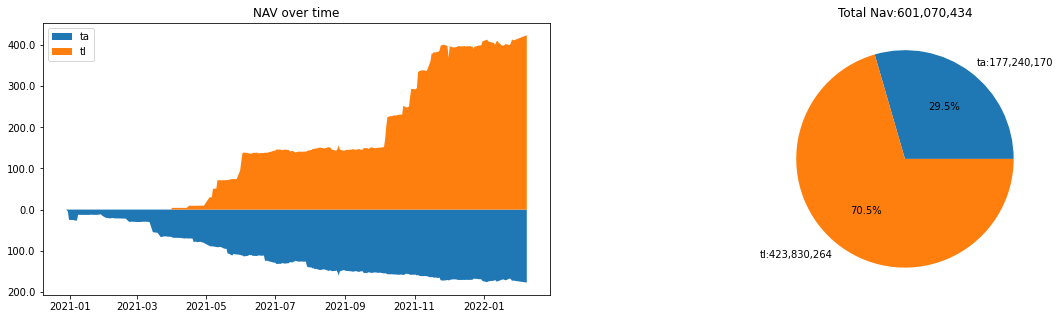

In [13]:
fig, (ax1, ax2) = plt.subplots(figsize=(20, 5), ncols=2)  # type: ignore


# Line plot
for i, user_name in enumerate(user_name_l):
    sign = -1 if i % 2 == 0 else 1
    ax1.fill_between(log_df.index, sign * log_df[user_name], label=user_name)

# set labels to absolute values
ax1.set_yticklabels(abs(ax1.get_yticks()/1_000_000))

ax1.set_title("NAV over time")
ax1.legend(loc="upper left")

# Pie chart
nav_l = [log_df[user_name].iloc[-1] for user_name in user_name_l]  # type: ignore
label_l = [f"{user_name}:{nav:,}" for user_name, nav in zip(user_name_l, nav_l)]
ax2.pie(nav_l, labels=label_l, autopct="%1.1f%%")

ax2.set_title(f"Total Nav:{np.sum(nav_l):,}")


plt.show()


## [Chart] Profit

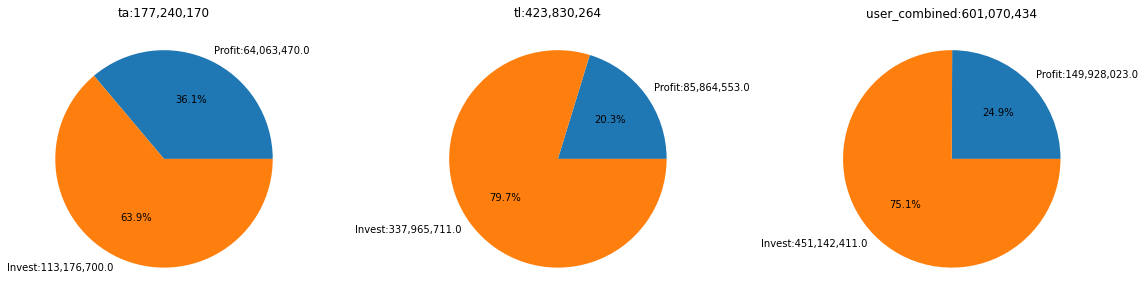

In [14]:
fig, ax_l = plt.subplots(figsize=(20, 5), ncols=3, facecolor="white")  # type: ignore

for name, ax in zip(user_name_combined_l, ax_l):  # type: ignore
    nav = log_df[name].iloc[-1]
    invest = -cf_df[name].sum()
    profit = nav - invest

    profit_label = f"Profit:{profit:,}"
    invest_label = f"Invest:{invest:,}"

    ax.pie([profit, invest], labels=[profit_label, invest_label], autopct="%1.1f%%")
    ax.set_title(f"{name}:{nav:,}")

plt.show()


## [Chart] Diff percent


### Histogram

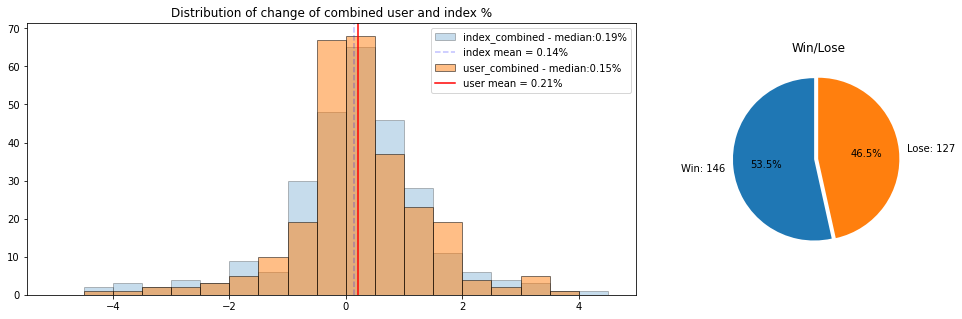

In [15]:
fig, (ax1, ax2) = plt.subplots(
    figsize=(16, 5),
    ncols=2,
    gridspec_kw={"width_ratios": [3, 1]},
)  # type: ignore

index_diff_p_l = log_df[f"{index_combined}_diff_p"] * 100
user_diff_p_l = log_df[f"{user_combined}_diff_p"] * 100

# *** Histogram ***

bins = np.arange(-5, 5, 0.5).tolist()

# Index histogram
index_combined_median = index_diff_p_l.median()
ax1.hist(
    index_diff_p_l,
    bins=bins,
    edgecolor="black",
    alpha=0.25,
    label=f"{index_combined} - median:{index_combined_median:.2f}%",
)
index_diff_p_mean = index_diff_p_l.mean()  # type: ignore

ax1.axvline(
    index_diff_p_mean,
    color="blue",
    linestyle="--",
    label="index mean = %.2f%%" % index_diff_p_mean,
    alpha=0.25,
)

# User histogram
user_combined_median = user_diff_p_l.median()
ax1.hist(
    user_diff_p_l,
    bins=bins,
    edgecolor="black",
    alpha=0.5,
    label=f"{user_combined} - median:{user_combined_median:.2f}%",
)
user_diff_p_mean = user_diff_p_l.mean()  # type: ignore
ax1.axvline(
    user_diff_p_mean,
    color="red",
    label="user mean = %.2f%%" % user_diff_p_mean,
)


ax1.set_title("Distribution of change of combined user and index %")
ax1.legend()

# *** Win / Lose pie chart ***
win_num = (user_diff_p_l > index_diff_p_l).sum()
lose_num = (user_diff_p_l <= index_diff_p_l).sum()
ax2.pie(
    [win_num, lose_num],
    labels=[f"Win: {win_num}", f"Lose: {lose_num}"],
    autopct="%1.1f%%",
    startangle=90,
    explode=[0.05, 0],
)
ax2.set_title("Win/Lose")

plt.show()


### Scatter plot


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


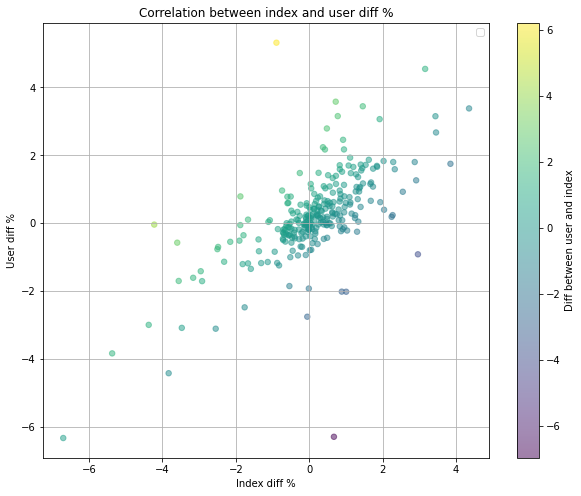

In [16]:
plt.figure(figsize=(10, 8))

index_diff_p_l = log_df[f"{index_combined}_diff_p"] * 100
user_diff_p_l = log_df[f"{user_combined}_diff_p"] * 100
plt.scatter(
    index_diff_p_l,
    user_diff_p_l,
    c=user_diff_p_l - index_diff_p_l,  # type: ignore
    s=30,
    alpha=0.5,
)

cbar = plt.colorbar()
cbar.set_label("Diff between user and index")

plt.title("Correlation between index and user diff %")
plt.xlabel("Index diff %")
plt.ylabel("User diff %")

plt.legend()
plt.grid(True)
plt.show()


## [Chart] Growth


In [17]:
log_df.iloc[-5:]

,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff,user_combined,user_combined_diff,index_combined,index_combined_diff,ta_diff_p,ta_aux_diff_p,tl_diff_p,tl_aux_diff_p,user_combined_diff_p,user_combined_aux_diff_p,vni_diff_p,vni_aux_diff_p,vn30_diff_p,vn30_aux_diff_p,index_combined_diff_p,index_combined_aux_diff_p
date,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15,587564965,12856268.0,1503.445,5.575,0.022424,1.022424,0.022347,1.022347,0.022370,1.022370,0.001352,1.001352,0.006035,1.006035,0.003722,1.003722
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74,584383923,-3181042.0,1493.665,-9.780,-0.004967,0.995033,-0.005601,0.994399,-0.005414,0.994586,-0.007303,0.992697,-0.005730,0.994270,-0.006505,0.993495
2022-01-28,173094888,412223583,1478.96,1532.24,600287.0,1758140.0,8.20,15.67,585318471,2358427.0,1505.600,11.935,0.003480,1.003480,0.004268,1.004268,0.004036,1.004036,0.005575,1.005575,0.010333,1.010333,0.007990,1.007990
2022-02-07,177204864,423039188,1497.66,1541.25,3557976.0,10815605.0,18.70,9.01,600244052,14373581.0,1519.455,13.855,0.020555,1.020555,0.026237,1.026237,0.024557,1.024557,0.012644,1.012644,0.005880,1.005880,0.009202,1.009202
2022-02-08,177240170,423830264,1497.66,1541.25,35306.0,791076.0,0.00,0.00,601070434,826382.0,1519.455,0.000,0.000199,1.000199,0.001870,1.001870,0.001377,1.001377,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000


### Latest growth

/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_43551/2588311270.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_43551/2588311270.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_43551/2588311270.py:48: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_43551/2588311270.py:48: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument wil

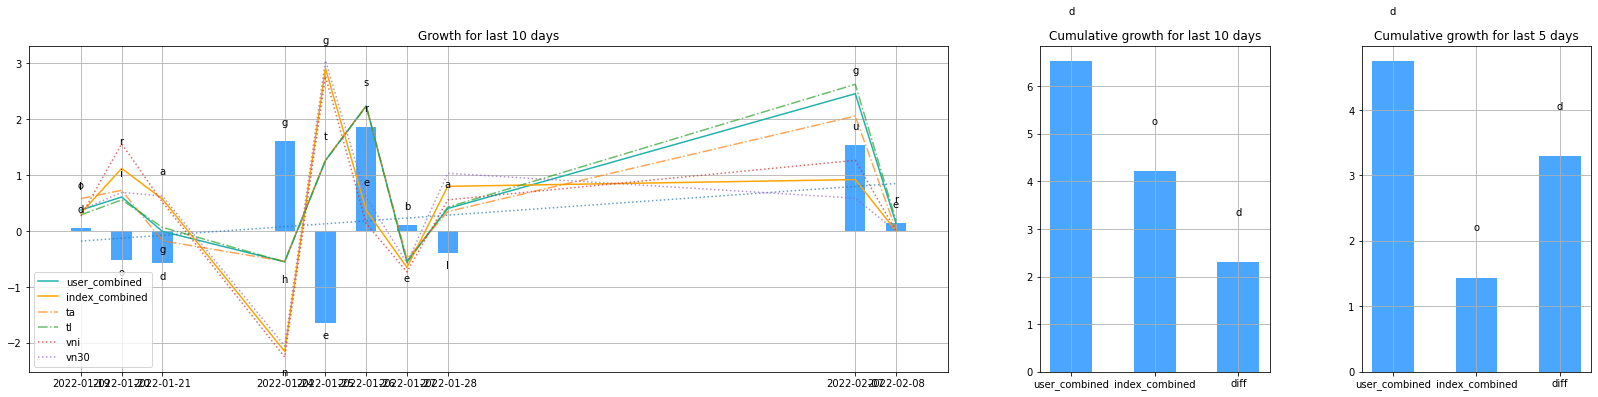

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(
    figsize=(28, 6),
    ncols=3,
    # sharey=True,
    gridspec_kw={"width_ratios": [4, 1, 1]},
)  # type: ignore

# * Last x days line plot

last_10_days_df = log_df.iloc[-10:]

for combined_name, color in zip(
    [user_combined, index_combined], ["lightseagreen", "orange"]
):
    x = last_10_days_df.index
    y = last_10_days_df[f"{combined_name}_diff_p"] * 100
    ax1.plot_date(
        x,
        y,
        linestyle="-",
        marker=None,
        label=combined_name,
        color=color,
    )
    add_labels(ax1, x, y, color)

last_10_days_diff = (
    last_10_days_df[f"{user_combined}_diff_p"]
    - last_10_days_df[f"{index_combined}_diff_p"]
) * 100

ax1.bar(
    last_10_days_df.index,
    last_10_days_diff,
    width=0.5,
    alpha=0.8,
    color="dodgerblue",
)
add_labels(ax1, last_10_days_df.index, last_10_days_diff, "dodgerblue")

# Trendline
first_date = last_10_days_df.index[0]
x = [(date - first_date).days for date in last_10_days_df.index]
add_trend_line(ax1, ticks=last_10_days_df.index, x=x, y=last_10_days_diff)


for single_name in user_name_l:
    ax1.plot_date(
        last_10_days_df.index,
        last_10_days_df[f"{single_name}_diff_p"] * 100,
        linestyle="-.",
        marker=None,
        alpha=0.7,
        label=single_name,
    )

for single_name in index_name_l:
    ax1.plot_date(
        last_10_days_df.index,
        last_10_days_df[f"{single_name}_diff_p"] * 100,
        linestyle=":",
        marker=None,
        alpha=0.7,
        label=single_name,
    )


ax1.set_title("Growth for last 10 days")
ax1.set_xticks(ticks=last_10_days_df.index)
ax1.legend()
ax1.grid(True)


# * Cumulative growth bar plot
def _plot_cum_growth(df: pd.DataFrame, ax: plt.Axes, day_num: int) -> None:
    cum_user_growth = (df[f"{user_combined}_aux_diff_p"].product() - 1) * 100  # type: ignore
    cum_index_growth = (df[f"{index_combined}_aux_diff_p"].product() - 1) * 100  # type: ignore
    cum_diff_growth = cum_user_growth - cum_index_growth
    x = [user_combined, index_combined, "diff"]
    y = [cum_user_growth, cum_index_growth, cum_diff_growth]
    ax.bar(
        x,
        y,
        width=0.5,
        alpha=0.8,
        color="dodgerblue",
    )
    ax.set_title(f"Cumulative growth for last {day_num} days")
    ax.grid(True)
    add_labels(ax, x, y, "dodgerblue")


_plot_cum_growth(last_10_days_df, ax2, 10)
_plot_cum_growth(last_10_days_df.iloc[-5:], ax3, 5)

plt.show()


In [19]:
last_10_days_df

,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff,user_combined,user_combined_diff,index_combined,index_combined_diff,ta_diff_p,ta_aux_diff_p,tl_diff_p,tl_aux_diff_p,user_combined_diff_p,user_combined_aux_diff_p,vni_diff_p,vni_aux_diff_p,vn30_diff_p,vn30_aux_diff_p,index_combined_diff_p,index_combined_aux_diff_p
date,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-19,170623200,399849051,1442.79,1482.55,983412.0,1153570.0,3.85,5.49,570472251,2136982.0,1462.670,4.670,0.005797,1.005797,0.002893,1.002893,0.003760,1.003760,0.002676,1.002676,0.003717,1.003717,0.003203,1.003203
2022-01-20,171867752,402077879,1465.30,1492.81,1244552.0,2228828.0,22.51,10.26,573945631,3473380.0,1479.055,16.385,0.007294,1.007294,0.005574,1.005574,0.006089,1.006089,0.015602,1.015602,0.006921,1.006921,0.011202,1.011202
2022-01-21,171568151,402345708,1472.89,1502.16,-299601.0,267829.0,7.59,9.35,573913859,-31772.0,1487.525,8.470,-0.001743,0.998257,0.000666,1.000666,-0.000055,0.999945,0.005180,1.005180,0.006263,1.006263,0.005727,1.005727
2022-01-24,167416073,400128653,1439.71,1471.31,-928078.0,-2217055.0,-33.18,-30.85,567544726,-3145133.0,1455.510,-32.015,-0.005409,0.994591,-0.005510,0.994490,-0.005480,0.994520,-0.022527,0.977473,-0.020537,0.979463,-0.021522,0.978478
2022-01-25,169543555,405165142,1479.58,1516.16,2127482.0,5036489.0,39.87,44.85,574708697,7163971.0,1497.870,42.360,0.012708,1.012708,0.012587,1.012587,0.012623,1.012623,0.027693,1.027693,0.030483,1.030483,0.029103,1.029103
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15,587564965,12856268.0,1503.445,5.575,0.022424,1.022424,0.022347,1.022347,0.022370,1.022370,0.001352,1.001352,0.006035,1.006035,0.003722,1.003722
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74,584383923,-3181042.0,1493.665,-9.780,-0.004967,0.995033,-0.005601,0.994399,-0.005414,0.994586,-0.007303,0.992697,-0.005730,0.994270,-0.006505,0.993495
2022-01-28,173094888,412223583,1478.96,1532.24,600287.0,1758140.0,8.20,15.67,585318471,2358427.0,1505.600,11.935,0.003480,1.003480,0.004268,1.004268,0.004036,1.004036,0.005575,1.005575,0.010333,1.010333,0.007990,1.007990
2022-02-07,177204864,423039188,1497.66,1541.25,3557976.0,10815605.0,18.70,9.01,600244052,14373581.0,1519.455,13.855,0.020555,1.020555,0.026237,1.026237,0.024557,1.024557,0.012644,1.012644,0.005880,1.005880,0.009202,1.009202


### XIRR

/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_43551/2272769585.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_43551/2272769585.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_43551/2272769585.py:49: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_43551/2272769585.py:49: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument wil

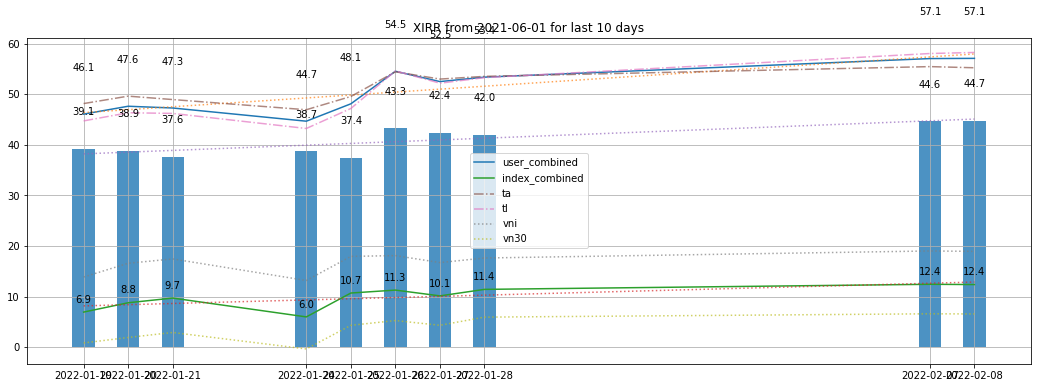

In [20]:
anchor_date = '2021-06-01'

xirr_data = {name:[] for name in user_name_combined_l+ index_name_combined_l}
for idx in log_df.index[-10:]:
    for name in user_name_combined_l:
        xirr_data[name].append(_calc_cashflow_xirr(cf_df, log_df,anchor_date, idx, name))
    for idx_name in index_name_combined_l:
        xirr_data[idx_name].append(_calc_index_xirr(log_df, anchor_date, idx, idx_name))
xirr_df = pd.DataFrame(xirr_data, index=log_df.index[-10:])


fig, ax1 = plt.subplots(figsize=(18, 6))  # type: ignore

# * Last x days line plot

for combined_name in [user_combined, index_combined]:
    ax1.plot_date(
        xirr_df.index,
        xirr_df[combined_name] * 100, # type: ignore
        linestyle="-",
        marker=None,
        label=combined_name,
    )
    add_labels(ax1, xirr_df.index, xirr_df[combined_name] * 100) # type: ignore

    # Trendline
    first_date = xirr_df.index[0]
    x = [(date - first_date).days for date in xirr_df.index]
    add_trend_line(ax1, ticks=xirr_df.index, x=x, y=xirr_df[combined_name] * 100) # type: ignore

last_x_days_diff = (xirr_df[user_combined] - xirr_df[index_combined]) * 100 # type: ignore

ax1.bar(
    xirr_df.index,
    last_x_days_diff,
    width=0.5,
    alpha=0.8,
)
add_labels(ax1, xirr_df.index, last_x_days_diff) # type: ignore

# Trendline
first_date = xirr_df.index[0]
x = [(date - first_date).days for date in xirr_df.index]
add_trend_line(ax1, ticks=xirr_df.index, x=x, y=last_x_days_diff) # type: ignore



for single_name in user_name_l:
    ax1.plot_date(
        xirr_df.index,
        xirr_df[single_name] * 100, # type: ignore
        linestyle="-.",
        marker=None,
        alpha=0.7,
        label=single_name,
    )

for single_name in index_name_l:
    ax1.plot_date(
        xirr_df.index,
        xirr_df[single_name] * 100, # type: ignore
        linestyle=":",
        marker=None,
        alpha=0.7,
        label=single_name,
    )


ax1.set_title(f"XIRR from {anchor_date} for last 10 days")
ax1.set_xticks(ticks=xirr_df.index)
ax1.legend()
ax1.grid(True)

plt.show()


In [21]:
xirr_df

,ta,tl,user_combined,vni,vn30,index_combined
date,,,,,,
2022-01-19,0.481562,0.447265,0.460701,0.138616,0.008266,0.069314
2022-01-20,0.496238,0.463414,0.476267,0.165799,0.019135,0.087746
2022-01-21,0.489496,0.462076,0.472801,0.174424,0.028983,0.097043
2022-01-24,0.469357,0.432309,0.446709,0.131799,-0.003606,0.059804
2022-01-25,0.495591,0.471841,0.481087,0.179403,0.043166,0.106999
2022-01-26,0.544379,0.546088,0.545420,0.181016,0.052570,0.112800
2022-01-27,0.529990,0.521849,0.525020,0.167172,0.043228,0.101366
2022-01-28,0.535337,0.532800,0.533788,0.176249,0.059343,0.114222
2022-02-07,0.554616,0.580508,0.570513,0.190160,0.065936,0.124268


### Growth time series


In [22]:
def get_overall_growth_xirr_df(
    log_df: pd.DataFrame,
    anchor_date: str = "2020-12-29",
) -> pd.DataFrame:
    filtered_log_df:pd.DataFrame = log_df[log_df.index >= anchor_date]  # type: ignore
    df = pd.DataFrame(index=filtered_log_df.index)
    for name in user_name_combined_l + index_name_combined_l:
        # set first date aux_diff_p to 1
        filtered_log_df[f"{name}_aux_diff_p"].iloc[0] = 1  # type: ignore
        # calculate growth using cumulative product since anchor date
        
        df[f"{name}_growth"] = filtered_log_df[f"{name}_aux_diff_p"].cumprod() * 100

    df = df.fillna(100)
        
    for name in user_name_combined_l:
        df[f"{name}_xirr"] = filtered_log_df.index.to_series().apply(
            lambda date_idx: _calc_cashflow_xirr(
                cf_df,
                log_df,
                anchor_date,
                date_idx,
                name,
            )
        ) * 100
        # The first few xirr are too crazy to be included
        df.iloc[:5, df.columns.get_loc(f"{name}_xirr")] = 0
        
    for name in index_name_combined_l:
        df[f"{name}_xirr"] = filtered_log_df.index.to_series().apply(
            lambda date_idx: _calc_index_xirr(
                log_df,
                anchor_date,
                date_idx,
                name,
            )
        ) * 100
        # The first few xirr are too crazy to be included
        df.iloc[:5, df.columns.get_loc(f"{name}_xirr")] = 0
    
    return df


/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_43551/4083471206.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_log_df[f"{name}_aux_diff_p"].iloc[0] = 1  # type: ignore
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_43551/4083471206.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_log_df[f"{name}_aux_diff_p"].iloc[0] = 1  # type: ignore
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_43551/4083471206.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

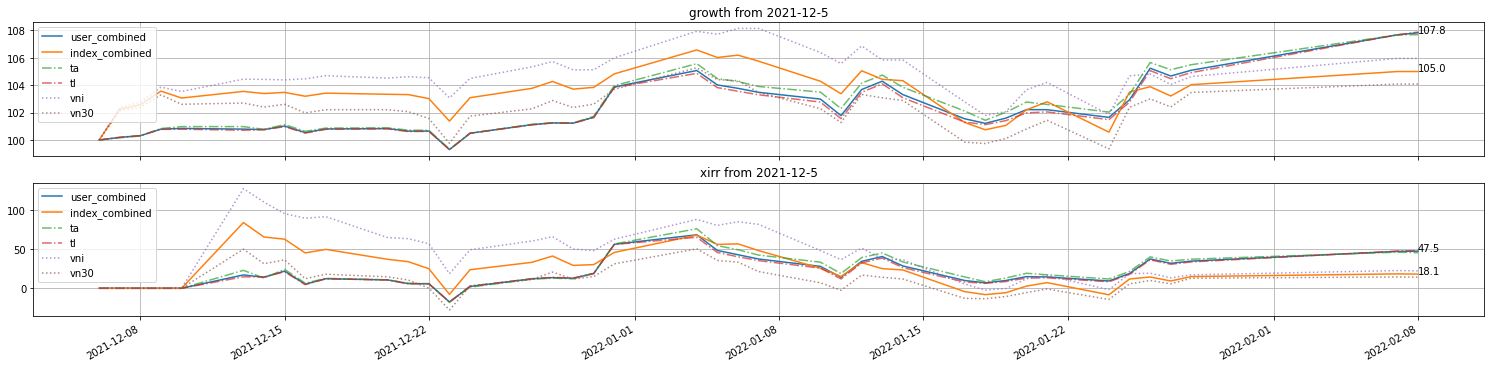

In [23]:
fig, (ax1, ax2) = plt.subplots(figsize=(26, 6), nrows=2)  # type: ignore

anchor_date = "2021-12-5"
growth_xirr_df = get_overall_growth_xirr_df(log_df, anchor_date=anchor_date)


def _plot_overall_growth_xirr(ax: plt.Axes, type: str):

    for combined_name in [user_combined, index_combined]:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{combined_name}_{type}"],
            linestyle="-",
            marker=None,
            label=combined_name,
        )
        ax.text(
            growth_xirr_df.index[-1],
            growth_xirr_df[f"{combined_name}_{type}"].iloc[-1],  # type: ignore
            f"{growth_xirr_df[f'{combined_name}_{type}'].iloc[-1]:.1f}",  # type: ignore
        )

    for single_name in user_name_l:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{single_name}_{type}"],
            linestyle="-.",
            marker=None,
            alpha=0.7,
            label=single_name,
        )

    for single_name in index_name_l:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{single_name}_{type}"],
            linestyle=":",
            marker=None,
            alpha=0.7,
            label=single_name,
        )

    ax.set_title(f"{type} from {anchor_date}")
    ax.legend(loc="upper left")
    ax.grid(True)
    fig.autofmt_xdate()
    
_plot_overall_growth_xirr(ax1, "growth")
_plot_overall_growth_xirr(ax2, "xirr")

plt.show()


In [24]:
growth_xirr_df

,ta_growth,tl_growth,user_combined_growth,vni_growth,vn30_growth,index_combined_growth,ta_xirr,tl_xirr,user_combined_xirr,vni_xirr,vn30_xirr,index_combined_xirr
date,,,,,,,,,,,,
2021-12-06,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-12-07,100.158760,100.199422,100.187192,102.347939,102.140561,102.241838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-12-08,100.292474,100.320109,100.311798,102.779468,102.379602,102.574883,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-12-09,100.835986,100.773401,100.792217,103.848385,103.287821,103.561582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-12-10,100.974915,100.783942,100.841362,103.534289,102.602436,103.057523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-12-13,100.974906,100.712055,100.791087,104.430595,102.692921,103.541544,22.969236,14.661712,17.101977,127.599464,50.070926,84.132500
2021-12-14,100.778605,100.747507,100.756856,104.417154,102.398509,103.384350,13.134879,14.574698,14.139654,110.303371,31.491026,65.627731
2021-12-15,101.121505,100.969112,101.014931,104.380368,102.599735,103.469338,24.163587,21.112513,22.022745,95.563485,36.433673,62.827152
2021-12-16,100.630390,100.499501,100.538855,104.458892,101.975124,103.188115,6.514377,4.699459,5.242327,89.692736,12.223287,45.295935


## [Process] Add period info


In [25]:
log_df["Y"] = log_df.index.to_period("Y")  # type: ignore
log_df["Q"] = log_df.index.to_period("Q")  # type: ignore
log_df["M"] = log_df.index.to_period("M")  # type: ignore
log_df.tail()


,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff,user_combined,user_combined_diff,index_combined,index_combined_diff,ta_diff_p,ta_aux_diff_p,tl_diff_p,tl_aux_diff_p,user_combined_diff_p,user_combined_aux_diff_p,vni_diff_p,vni_aux_diff_p,vn30_diff_p,vn30_aux_diff_p,index_combined_diff_p,index_combined_aux_diff_p,Y,Q,M
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15,587564965,12856268.0,1503.445,5.575,0.022424,1.022424,0.022347,1.022347,0.022370,1.022370,0.001352,1.001352,0.006035,1.006035,0.003722,1.003722,2022,2022Q1,2022-01
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74,584383923,-3181042.0,1493.665,-9.780,-0.004967,0.995033,-0.005601,0.994399,-0.005414,0.994586,-0.007303,0.992697,-0.005730,0.994270,-0.006505,0.993495,2022,2022Q1,2022-01
2022-01-28,173094888,412223583,1478.96,1532.24,600287.0,1758140.0,8.20,15.67,585318471,2358427.0,1505.600,11.935,0.003480,1.003480,0.004268,1.004268,0.004036,1.004036,0.005575,1.005575,0.010333,1.010333,0.007990,1.007990,2022,2022Q1,2022-01
2022-02-07,177204864,423039188,1497.66,1541.25,3557976.0,10815605.0,18.70,9.01,600244052,14373581.0,1519.455,13.855,0.020555,1.020555,0.026237,1.026237,0.024557,1.024557,0.012644,1.012644,0.005880,1.005880,0.009202,1.009202,2022,2022Q1,2022-02
2022-02-08,177240170,423830264,1497.66,1541.25,35306.0,791076.0,0.00,0.00,601070434,826382.0,1519.455,0.000,0.000199,1.000199,0.001870,1.001870,0.001377,1.001377,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2022,2022Q1,2022-02


In [26]:
def get_period_df(period_symbol, log_df):
    period_l = log_df[period_symbol].unique()

    data = []
    for period in period_l:
        period_data_dict = {"period": period}
        period_filt = log_df[period_symbol] == period
        period_df = log_df.loc[period_filt]

        for name in user_name_combined_l + index_name_combined_l:
            period_growth = period_df[f"{name}_aux_diff_p"].product()  # type: ignore
            period_data_dict[f"{name}_growth"] = (period_growth - 1) * 100  # type: ignore

        for user_name in user_name_combined_l:
            period_xirr = _calc_cashflow_xirr(
                cf_df,
                log_df,
                anchor_date=period_df.index[0],
                date_idx=period_df.index[-1],
                col_name=user_name,
            )  # type: ignore
            period_data_dict[f"{user_name}_xirr"] = period_xirr * 100  # type: ignore

            period_data_dict[f"{user_name}_income"] = period_df[f"{user_name}_diff"].sum()  # type: ignore

        for index_name in index_name_combined_l:
            period_xirr = _calc_index_xirr(
                log_df,
                anchor_date=period_df.index[0],
                date_idx=period_df.index[-1],
                index_name=index_name,
            )  # type: ignore
            period_data_dict[f"{index_name}_xirr"] = period_xirr * 100  # type: ignore

        data.append(period_data_dict)

    period_df = pd.DataFrame(data)
    period_df = period_df.set_index("period")
    period_df.index = period_df.index.to_series().astype(str)
    return period_df


In [27]:
def plot_growth_xirr(growth_xirr_df: pd.DataFrame, period_name: str):

    fig, (ax1, ax2, ax3, ax4, income_ax) = plt.subplots(
        nrows=5,
        ncols=1,
        sharex=True,
        figsize=(20, 12),
    )  # type: ignore

    # ****** GROWTH ******
    def _plot(
        net_ax: plt.Axes,
        diff_ax: plt.Axes,
        type: str,
        income_ax: plt.Axes = None,
    ):
        """
        Parameters
        type: is either 'growth' or 'xirr'
        """
        # * Draw bar chart

        x_indices = np.arange(len(growth_xirr_df.index))

        bar_name_l = user_name_l + index_name_l
        bar_count = len(bar_name_l)
        total_width = 0.6
        bar_width = total_width / bar_count

        for i, name in enumerate(bar_name_l):
            position = x_indices + i * bar_width
            net_ax.bar(
                position,
                growth_xirr_df[f"{name}_{type}"],
                label=name,
                width=bar_width,
            )

        # move back half bar width to left most edge and then move to the middle of the bar group
        ticks = x_indices - (0.5 * bar_width) + (bar_count / 2 * bar_width)

        # * Draw line chart

        for name, color in zip([user_combined, index_combined], ["orange", "orchid"]):
            net_ax.plot(
                ticks,
                growth_xirr_df[f"{name}_{type}"],
                label=name,
                linestyle="--",
                c=color,
            )

        net_ax.fill_between(
            ticks,
            growth_xirr_df[f"{user_combined}_{type}"],
            growth_xirr_df[f"{index_combined}_{type}"],
            where=(
                growth_xirr_df[f"{user_combined}_{type}"]
                >= growth_xirr_df[f"{index_combined}_{type}"]  # type: ignore
            ),
            color="green",
            interpolate=True,
            alpha=0.25,
        )

        net_ax.fill_between(
            ticks,
            growth_xirr_df[f"{user_combined}_{type}"],
            growth_xirr_df[f"{index_combined}_{type}"],
            where=(
                growth_xirr_df[f"{user_combined}_{type}"] < growth_xirr_df[f"{index_combined}_{type}"]  # type: ignore
            ),
            color="red",
            interpolate=True,
            alpha=0.25,
        )

        # * Decorations
        y = growth_xirr_df[f"{user_combined}_{type}"]  # type: ignore
        add_labels(
            ax=net_ax,
            x=ticks,
            y=y,
            color="orange",
        )

        net_ax.set_xticks(
            ticks=ticks,
            labels=growth_xirr_df.index,
            rotation=90,
        )

        net_ax.set_title(f"{period_name} {type}")
        net_ax.set_ylabel(f"{type} %")
        net_ax.legend(loc="upper left")

        net_ax.grid(True)

        # *** Diff ***
        diff_series = (
            growth_xirr_df[f"{user_combined}_{type}"] - growth_xirr_df[f"{index_combined}_{type}"]  # type: ignore
        )
        diff_ax.bar(
            ticks,
            diff_series,
            width=bar_width,
            label="Diff (user - index)",
            color="dodgerblue",
        )
        add_labels(
            ax=diff_ax,
            x=ticks,
            y=diff_series,
            color="dodgerblue",
        )
        y = growth_xirr_df[f"{index_combined}_{type}"]
        add_labels(
            ax=diff_ax,
            x=ticks,
            y=y,
            color="orchid",
        )

        add_trend_line(diff_ax, ticks, ticks, diff_series)

        # Growth line
        for name, color in zip([user_combined, index_combined], ["orange", "orchid"]):
            diff_ax.plot(
                ticks,
                growth_xirr_df[f"{name}_{type}"],
                label=name,
                marker="o",
                linestyle="-",
                color=color,
            )

        win_num = diff_series[diff_series > 0].count()  # type: ignore
        win_rate = win_num / len(diff_series) * 100

        diff_ax.set_title(f"Diff in {type} - win rate: {win_rate:.2f}%")
        diff_ax.set_ylabel(f"{type} %")
        diff_ax.legend(loc="upper left")
        diff_ax.grid(True)

        # Income
        if income_ax is not None:
            for name, color in zip(
                user_name_combined_l, ["dodgerblue", "orchid", "orange"]
            ):
                income_l = growth_xirr_df[f"{name}_income"]  # type: ignore
                income_ax.plot(
                    ticks,
                    income_l,
                    label=name,
                    color=color,
                )
                income_label_l = [f"{income:,.0f}" for income in income_l]
                add_labels(
                    ax=income_ax,
                    x=ticks,
                    y=income_l,
                    label_l=income_label_l,
                    color=color,
                )
            income_ax.set_title(f"{period_name} income")
            income_ax.grid(True)
            income_ax.legend(loc="upper left")

    _plot(ax1, ax2, "growth", income_ax=income_ax)
    _plot(ax3, ax4, "xirr")

    plt.show()


## [Chart] Monthly


In [28]:
monthly_df = get_period_df("M", log_df)
# Insufficient data for 2020-12
monthly_df.drop(["2020-12"], inplace=True)


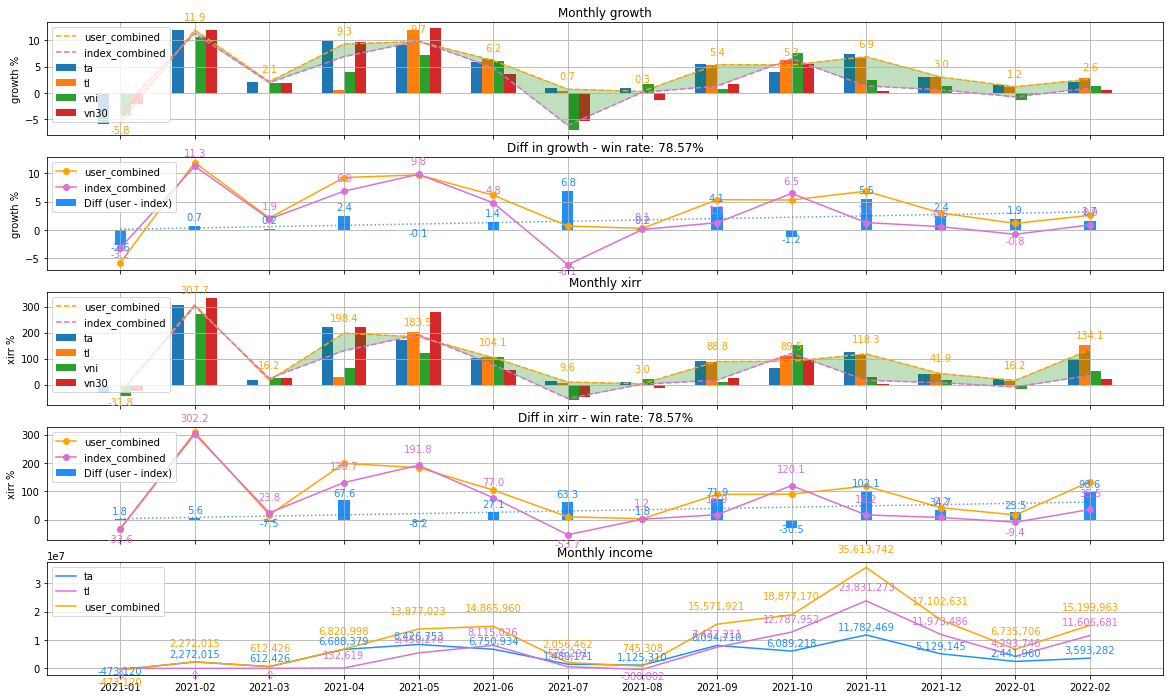

In [29]:
plot_growth_xirr(monthly_df, "Monthly")


In [30]:
monthly_df

,ta_growth,tl_growth,user_combined_growth,vni_growth,vn30_growth,index_combined_growth,ta_xirr,ta_income,tl_xirr,tl_income,user_combined_xirr,user_combined_income,vni_xirr,vn30_xirr,index_combined_xirr
period,,,,,,,,,,,,,,,
2021-01,-5.801495,0.000000,-5.801495,-4.281301,-2.097556,-3.206048,-31.824347,-473120.0,0.000000,0.0,-31.824347,-473120.0,-42.347039,-23.418211,-33.643602
2021-02,11.919800,0.000000,11.919800,10.586688,11.951617,11.266461,307.719272,2272015.0,0.000000,0.0,307.719272,2272015.0,271.276845,335.658231,302.153138
2021-03,2.130464,0.000000,2.130464,1.965819,1.929107,1.947423,16.237842,612426.0,0.000000,0.0,16.237842,612426.0,24.026106,23.533099,23.778840
2021-04,9.782790,0.567937,9.265127,4.024542,9.700395,6.868173,221.794495,6688379.0,29.034322,132619.0,198.363712,6820998.0,64.314113,220.677577,130.723459
2021-05,9.143898,11.870611,9.742956,7.153519,12.383028,9.842966,172.713866,8426753.0,203.195840,5450270.0,183.538912,13877023.0,119.918082,278.708624,191.781984
2021-06,5.797309,6.513758,6.157616,6.061519,3.676481,4.806571,102.328338,6750934.0,105.643285,8115026.0,104.112592,14865960.0,104.622667,55.158770,77.035437
2021-07,1.017875,0.402725,0.706302,-6.993007,-5.347940,-6.136747,14.870849,1480171.0,5.011513,576291.0,9.587606,2056462.0,-58.605767,-48.763137,-53.723216
2021-08,0.864777,-0.264489,0.295285,1.635052,-1.283141,0.103363,9.396137,1125310.0,-2.975650,-380002.0,3.012620,745308.0,20.320626,-13.696960,1.185342
2021-09,5.494308,5.218083,5.357257,0.795362,1.756891,1.293055,91.896611,8094710.0,85.680531,7477211.0,88.805787,15571921.0,10.118424,23.602312,16.919240


## Quaterly


In [31]:
quaterly_df = get_period_df("Q", log_df)
quaterly_df.drop(["2020Q4"], inplace=True)


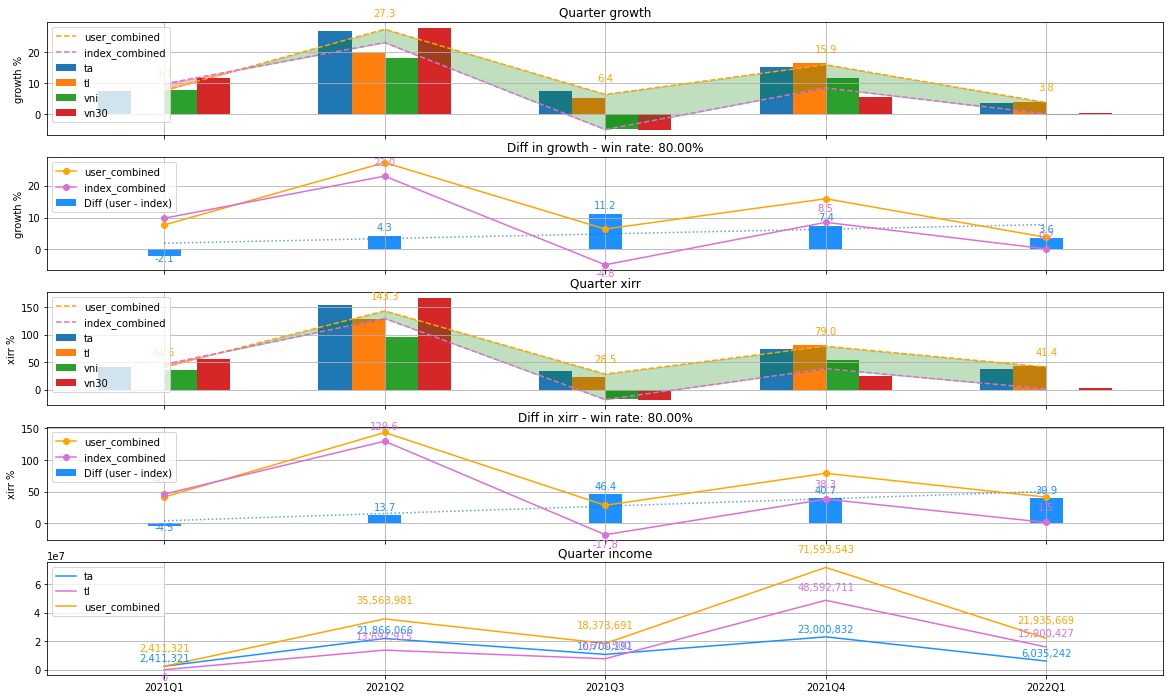

In [32]:
plot_growth_xirr(quaterly_df, "Quarter")


In [33]:
quaterly_df

,ta_growth,tl_growth,user_combined_growth,vni_growth,vn30_growth,index_combined_growth,ta_xirr,ta_income,tl_xirr,tl_income,user_combined_xirr,user_combined_income,vni_xirr,vn30_xirr,index_combined_xirr
period,,,,,,,,,,,,,,,
2021Q1,7.672858,0.000000,7.672858,7.932999,11.717736,9.796564,41.598018,2411321.0,0.000000,0.0,41.598018,2411321.0,36.288398,56.733544,46.086448
2021Q2,26.767623,19.834332,27.294426,18.222487,27.817160,23.029468,154.510835,21866066.0,127.891901,13697915.0,143.347875,35563981.0,95.703804,167.625795,129.628450
2021Q3,7.489684,5.362412,6.414699,-4.720457,-4.920863,-4.824769,34.455969,10700191.0,23.027746,7673500.0,28.543260,18373691.0,-17.456391,-18.143055,-17.814336
2021Q4,15.080954,16.638849,15.924224,11.640314,5.637107,8.518789,74.305147,23000832.0,81.492486,48592711.0,79.025576,71593543.0,54.783555,24.305219,38.312675
2022Q1,3.573585,3.894043,3.800810,-0.041381,0.360745,0.162163,37.927319,6035242.0,42.900510,15900427.0,41.407679,21935669.0,-0.386613,3.427562,1.528004


## Yearly

In [34]:
yearly_df = get_period_df("Y", log_df)
yearly_df.drop(["2020"], inplace=True)

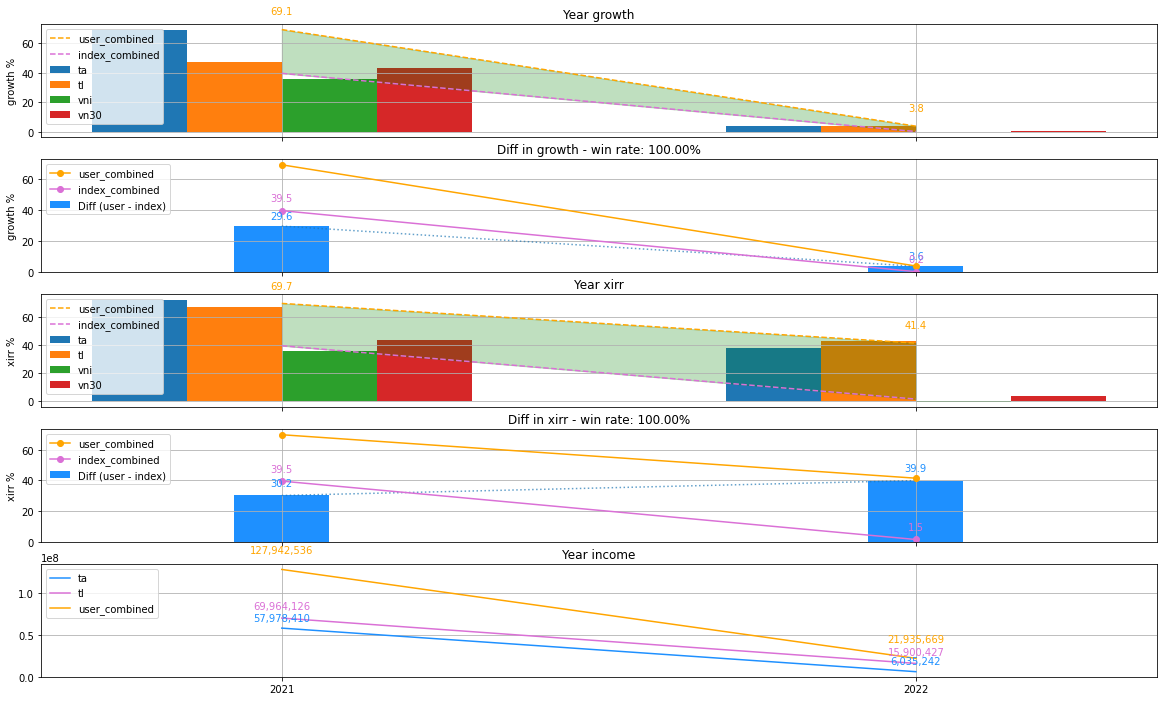

In [35]:
plot_growth_xirr(yearly_df, "Year")